In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import random
from torch.utils.data import DataLoader
from random import randint
from augment_functions import random_mask
import torch.nn.functional as F

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def resize_encoder(sample):
    sample = F.interpolate(sample, size=(144, 72), mode='bicubic', align_corners=False)
    return sample

def random_mask(sample, mask_prob_low=0.7, mask_prob_high=0.7):
    if mask_prob_low == mask_prob_high:
        mask_prob = mask_prob_low
    else:
        mask_prob = random.uniform(mask_prob_low, mask_prob_high)
    random_tensor = torch.rand(sample.shape, device=sample.device)
    mask = (random_tensor > mask_prob).float()
    masked_image = sample * mask
    return masked_image

class WeatherBenchDatasetWindow(Dataset):
    def __init__(self, data, context_length, target_length, stride=1, mask_prob_low=0.7, mask_prob_high=0.7):
        self.data = data
        self.context_length = context_length
        self.target_length = target_length
        self.stride = stride
        self.mask_prob_low=mask_prob_low
        self.mask_prob_high=mask_prob_high
        
    def __len__(self):
        return (self.data.shape[0] - (self.context_length + self.target_length)) // self.stride + 1

    def __getitem__(self, idx):
        start = idx * self.stride
        end_context = start + self.context_length
        end_target = end_context + self.target_length
        x = random_mask(resize_encoder(self.data[start:end_context]), mask_prob_low=self.mask_prob_low, mask_prob_high=self.mask_prob_high)
        y = self.data[end_context:end_target]
        y_masked = random_mask(resize_encoder(y), mask_prob_low=self.mask_prob_low, mask_prob_high=self.mask_prob_high)
        return x, y_masked, idx

In [4]:
model = torch.load('simclr_decoder.pth', weights_only=False, map_location=DEVICE)
model.eval()

model = model.model.encoder

BATCH_SIZE = 64
CW = 5
data = torch.load('/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt')
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train:n_train+n_valid]
test_data = data[n_train+n_valid:]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDatasetWindow(data=test_data, context_length=CW, target_length=1, stride=5, mask_prob_low=0.7, mask_prob_high=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [5]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[0].to(DEVICE)
next_x = batch[1].to(DEVICE)
y = batch[2].to(DEVICE)

In [6]:
B, T, C, H, W = x.shape
x = x.reshape(B*T, C, H, W)
B_nx, T_nx, C_nx, H_nx, W_nx = next_x.shape
next_x = next_x.reshape(B_nx*T_nx, C_nx, H_nx, W_nx)
with torch.no_grad():
    embeddings_x, _ = model(x)
    embeddings_next_x, _ = model(next_x)
embeddings_x = embeddings_x.reshape(B, T, -1)
embeddings_x = embeddings_x.mean(dim=1) 
embeddings_next_x = embeddings_next_x.reshape(B_nx, T_nx, -1).mean(dim=1) 

In [7]:
embeddings_x = embeddings_x.cpu().numpy()
embeddings_next_x = embeddings_next_x.cpu().numpy()
y = y.cpu().numpy()

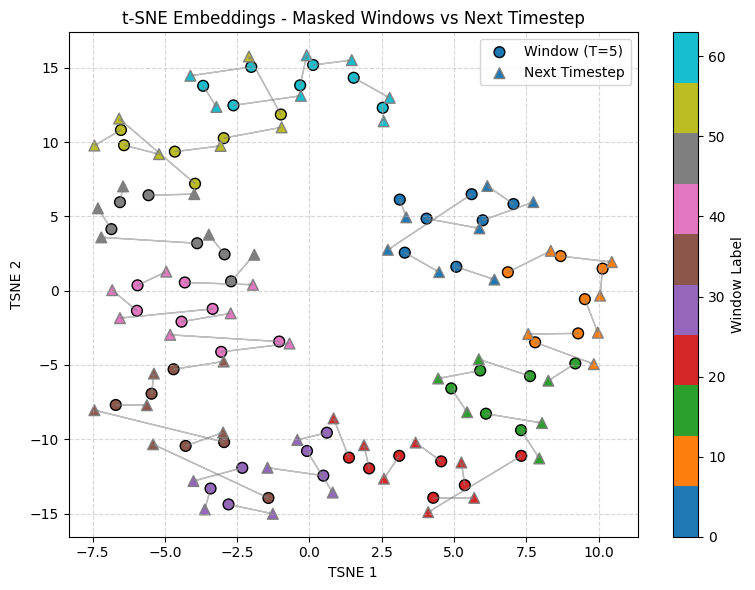

In [8]:
combined = np.vstack([embeddings_x, embeddings_next_x])
pca = TSNE(n_components = 2)
pca_embeddings_x = pca.fit_transform(combined)

PLOT_NUM = 64

plot_num = min(PLOT_NUM, BATCH_SIZE)

emb_2d = pca_embeddings_x[:BATCH_SIZE]

next_emb_2d = pca_embeddings_x[BATCH_SIZE:]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(emb_2d[:plot_num, 0], emb_2d[:plot_num, 1],
            c=y[:plot_num], cmap='tab10', label=f'Window (T={CW})', s=60, edgecolors='k')
plt.scatter(next_emb_2d[:plot_num, 0], next_emb_2d[:plot_num, 1],
            c=y[:plot_num], cmap='tab10', marker='^', label='Next Timestep', s=60, edgecolors='gray')
for i in range(plot_num):
    plt.arrow(emb_2d[i, 0], emb_2d[i, 1],
              next_emb_2d[i, 0] - emb_2d[i, 0],
              next_emb_2d[i, 1] - emb_2d[i, 1],
              color='gray', alpha=0.5, head_width=0.1, length_includes_head=True)

plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.title('t-SNE Embeddings - Masked Windows vs Next Timestep')
plt.colorbar(scatter, label='Window Label')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()